In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

import ase
from ase import Atoms
from ase.io import read

import pyTEMlib
import pyTEMlib.file_tools as ft

from scipy.ndimage import gaussian_filter
from skimage.util import random_noise
from skimage.draw import disk
from sklearn.neighbors import KDTree

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available


In [2]:
dataset = ft.open_file('/Users/austin/Desktop/Projects/PdSe Paper/Nion Swift Project 20221114 PdSeRich Data/2022/11/14/20221114-143647/data_SBIL9XP6LJEU2RLNL88IO78WI.ndata')
image = dataset['Channel_000']
#dataset['Channel_000'].original_metadata

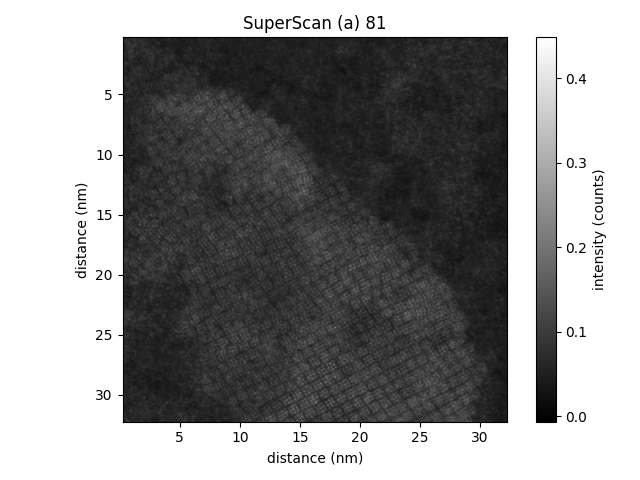

In [3]:
view = image.plot(cmap='gray')

## Load structure

In [4]:
# dft structure

PdSeM = read(filename = './PdSeM.cif')
#lattice_coordinates = np.load('./PdSeM_lattice_coordinates.npy')

fov = 320 # Angstroms
image_size = 2048

## Define some useful functions

In [5]:
def make_lattice_coords(xtal, fov = fov,image_size = image_size):
    # how many unit cells fit in the image
    n_cells = (int(fov/xtal.cell[0,0]),int(fov/xtal.cell[1,1]),1)
    xtal_master = xtal * n_cells
    # get all middle atom position [x,y]
    pos = xtal_master.positions
    zmin = 12
    zmax = 14
    proj_2d_positions = pos[(zmax > pos[:,2]) & (pos[:,2] > zmin)][:,:2].round(decimals = 2)

    # for a single unit cell
    # Cols = Se3, PdSe2, Pd2Se1
    # Z    = 102, 114, 126
    atomic_numbers = np.array([102, 114, 102,
                                114, 92, 114,
                                102, 114, 102]) 
    atomic_numbers = atomic_numbers/atomic_numbers.max()

    atom_ids = np.array([0,1,0,
                        1,2,1,
                        0,1,0]) + 1 # bkg is labeled 0

    intensity = np.tile(np.square(atomic_numbers), (n_cells[0]*n_cells[1], 1)).reshape(9*n_cells[0]*n_cells[1],1)
    identity = np.tile(atom_ids, (n_cells[0]*n_cells[1], 1)).reshape(9*n_cells[0]*n_cells[1],1)
    int_id_stack = np.hstack((intensity,identity))

    lattice = np.hstack((proj_2d_positions,int_id_stack))

    return lattice

def make_image(lattice, fov = fov, image_size = image_size, atom_blur = 5, image_blur = 1, n_holes = 9, hole_size = 3, max_rotation = 180, randomize_pos = 0.15, gauss_noise = 0.05, salt_pepper = 0.01, atom_r = 3):
    # empty image
    image_master = np.zeros(shape = (image_size, image_size))
    mask_gt = np.zeros(shape = (image_size, image_size))
    # rotate atoms
    theta = max_rotation * np.random.random() * np.pi / 180 # deg to rad
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    center = [fov//2,fov//2]
    translated_coords = lattice[:,:2] - np.array(center)
    rotated_atom_pos = np.dot(translated_coords, rotation_matrix)
    rotated_atom_pos += center
    rotated_atoms = np.hstack((rotated_atom_pos, lattice[:,2:4].reshape(-1,2)))

    # randomize positions
    temperature = randomize_pos * np.random.random(np.shape(lattice[:,:2]))
    rotated_atoms[:,:2] += temperature

    # filter by the edges
    in_frame = np.logical_and(rotated_atoms[:,:2] > 0+atom_r, rotated_atoms[:,:2] < fov-atom_r)
    edge_mask = np.all(in_frame, axis = 1)
    rotated_atoms = rotated_atoms[edge_mask]

    # making holes
    kdtree = KDTree(rotated_atoms[:,:2])
    hole_indices = np.random.choice(len(rotated_atoms), n_holes, replace=False)
    holes = rotated_atoms[:, :2][hole_indices]
    points_to_remove = []
    for hole in holes:
        near_points_indices = kdtree.query_radius([hole], r=hole_size)[0]
        points_to_remove.extend(near_points_indices)
    rotated_atoms = np.delete(rotated_atoms, points_to_remove, axis=0)


    xmesh, ymesh = np.meshgrid(np.arange(image_size),np.arange(image_size))
    # add atoms to image
    for x,y,intensity,id in rotated_atoms:
        # convert Ang to pixels
        x,y = int(image_size*x/fov), int(image_size*y/fov)
        # add atom to image
        image_master[x,y] = intensity
        # add atom to gt_mask
        rr,cc = disk((y,x), atom_r+1)
        mask_gt[rr,cc] = id
    mask_gt = mask_gt.T    
    # convolve with gaussian
    image_master = gaussian_filter(image_master, sigma = atom_blur)
    image_master = image_master/np.max(image_master)

    # add noise
    image_master = random_noise(image_master, mode='gaussian', var=gauss_noise)
    if not salt_pepper == 0:
        image_master = random_noise(image_master, mode='pepper', amount=salt_pepper)
        image_master = random_noise(image_master, mode='salt', amount=salt_pepper)

    image_master = gaussian_filter(image_master, sigma = image_blur)
    image_master = image_master.astype('float16')
    image_master = image_master/np.max(image_master)

    return image_master, mask_gt

def make_batches(image_master, mask_gt, crop_size=256, crop_glide=128):

    n_crops = int((len(image_master) - crop_size)/crop_glide + 1)
    batch_ims = np.zeros((n_crops,n_crops,crop_size,crop_size))
    batch_masks = np.zeros((n_crops,n_crops,crop_size,crop_size))

    for x in np.arange(n_crops):
        for y in np.arange(n_crops):
            xx,yy = int(x*crop_glide), int(y*crop_glide)
            batch_ims[int(x),int(y)] = image_master[xx:xx+crop_size,yy:yy+crop_size]
            batch_masks[int(x),int(y)] = mask_gt[xx:xx+crop_size,yy:yy+crop_size]
    batch_ims = batch_ims.reshape((-1,crop_size,crop_size)).astype('float16')
    batch_masks = batch_masks.reshape((-1,crop_size,crop_size)).astype('float16')
    
    return batch_ims, batch_masks

## Generate training data

In [6]:
n_batches = 10

X_train = []
y_train = []

for _ in range(n_batches):
    lattice = make_lattice_coords(PdSeM)
    image_master, mask_gt = make_image(lattice, image_size = 4096, atom_blur = 3, image_blur = 3, hole_size = 15, n_holes = 20, randomize_pos = 0.9, gauss_noise = 0.2, salt_pepper = 0.005, atom_r = 3)
    batch_ims, batch_masks = make_batches(image_master, mask_gt, crop_size=2048, crop_glide=1024)
    X_train.append(batch_ims)
    y_train.append(batch_masks)
X_train = X_train
y_train = y_train

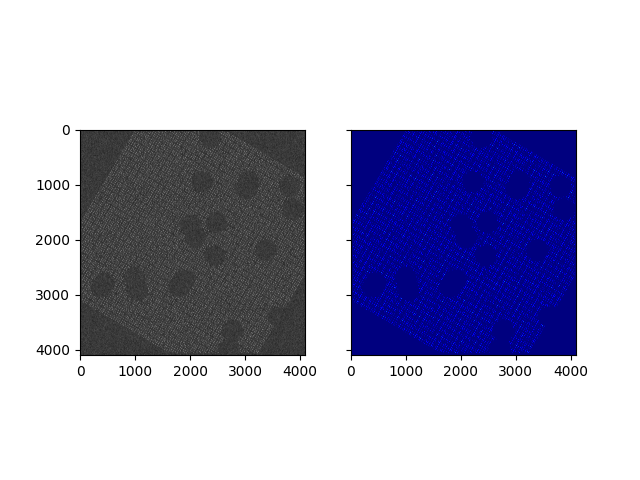

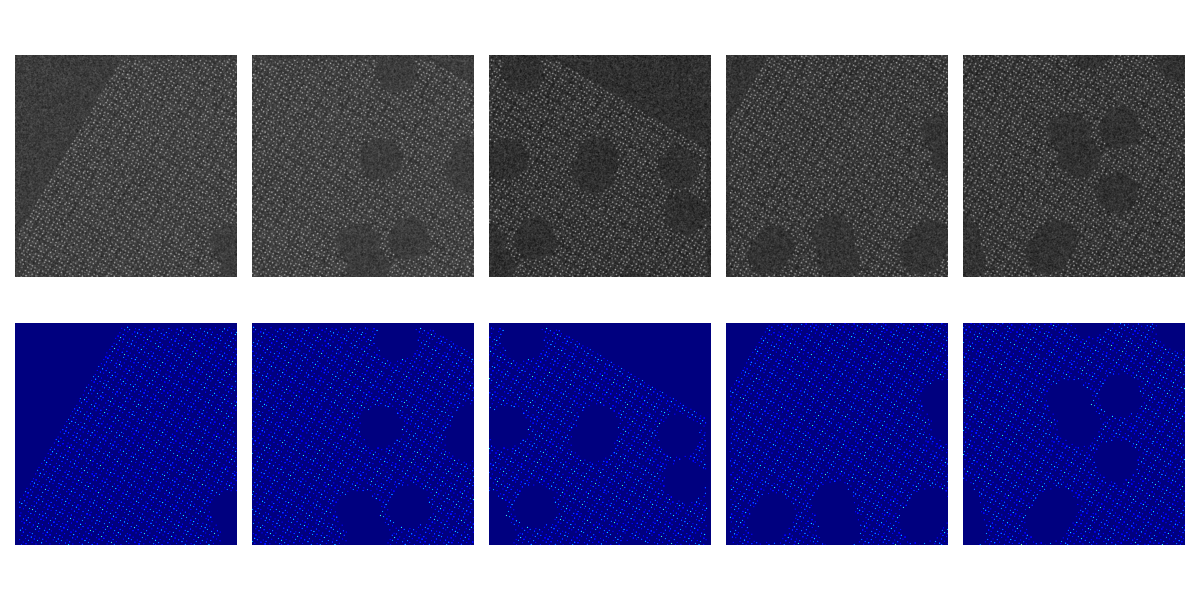

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)
ax1.imshow(image_master, cmap = 'gray')
ax2.imshow(mask_gt,cmap = 'jet')

fig, axs = plt.subplots(2,5, figsize=(12,6))
axs[0,0].imshow(batch_ims[0],cmap='gray')
axs[1,0].imshow(batch_masks[0],cmap='jet')
axs[0,1].imshow(batch_ims[1],cmap='gray')
axs[1,1].imshow(batch_masks[1],cmap='jet')
axs[0,2].imshow(batch_ims[2],cmap='gray')
axs[1,2].imshow(batch_masks[2],cmap='jet')
axs[0,3].imshow(batch_ims[3],cmap='gray')
axs[1,3].imshow(batch_masks[3],cmap='jet')
axs[0,4].imshow(batch_ims[4],cmap='gray')
axs[1,4].imshow(batch_masks[4],cmap='jet')
for ax in axs.ravel():
    ax.set_axis_off()
fig.tight_layout()

In [8]:
thresh = int(n_batches * .75) # ~ 75-25 split
X_train, X_test = X_train[:thresh], X_train[thresh:]
y_train, y_test = y_train[:thresh], y_train[thresh:]

In [9]:
np.savez('../PdSeM_train_test_2048_10.npz',
         X_train=X_train,y_train=y_train,
         X_test=X_test, y_test=y_test)